# Exploration-Exploitation in Reinforcement Learning

In this homework, you will implement the **UCBVI** algorithm, for exploration in MDPs with finite states and actions and a **finite horizon** criterion. In a finite horizon criterion, the value function of a policy (starting from the $h$ step of the episode) is

$$V_h^{\pi}(s) = \mathbb{E}^{\pi}\left[\left.\sum_{\ell = h}^{H} \gamma^{\ell-h} r_{\ell} \right| s_h = s\right]$$

where the discount parameter $\gamma \in (0,1]$ is often set to $\gamma = 1$.

### Useful libraries

We will need a some tabular RL environments that are implemented in the rlberry-scool library, that is developped within the Inria team Scool. You can  install it below (in a conda env if you do it locally).

In [47]:
!pip install rlberry-scool

In [48]:
# other useful imports
import numpy as np
import numba
import matplotlib.pyplot as plt
from copy import deepcopy
import gymnasium as gym
from gymnasium.wrappers import RecordVideo
from IPython.display import Video, Image
from rlberry_scool.envs.finite import get_discrete_mountain_car_env


## Environment

Our goal is to learn a good policy in a [Mountain Car](https://gymnasium.farama.org/environments/classic_control/mountain_car/) environment. The Mountain Car environement as implemented in gymnasium has a continuous state space. In order to apply UCBVI, we will use a discretized version from the rlberry library.

In [49]:
def record_video(env, name, horizon=180,policy=None):
    """
    input
    horizon : length of the simulation
    policy : either a determinstic policy represented by an (H,S) array
    or a random policy which is uniform (None)
    """
    env = deepcopy(env)
    env = RecordVideo(env, "./gym_videos/"+name)
    s, _ = env.reset()
    done = False
    tot_reward = 0
    h = 0
    while not done:
        if policy is not None:
            action = policy[h, s]
        else:
            action = env.action_space.sample()
        s, r, term, trunc, infos = env.step(action)
        h += 1
        tot_reward += r
        done = (term or trunc) or h >= horizon
    env.close()
    print("Reward sum: {}".format(tot_reward))


In [50]:
class ScaleRewardWrapper(gym.RewardWrapper):
    def __init__(self, env):
        super().__init__(env)

    def step(self, action):
        next_state, reward, term, trunc, info = self.env.step(action)
        if term:
            reward = 1.0
        else:
            reward = 0.0

        return (next_state,reward,term,trunc,info)

With the reward wrapper above, the agent gets a reward 0 in states that are not the top of the right hill. Once the goal state is reached, the agent stays in this state and gets a reward 1 until the end of the episode.

In [51]:
env = ScaleRewardWrapper(get_discrete_mountain_car_env())
record_video(env, name="Random-MountainCar") #saves the video

/usr/local/lib/python3.10/dist-packages/gymnasium/wrappers/record_video.py:94: UserWarning: WARN: Overwriting existing videos at /content/gym_videos/Random-MountainCar folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


Moviepy - Building video /content/gym_videos/Random-MountainCar/rl-video-episode-0.mp4.
Moviepy - Writing video /content/gym_videos/Random-MountainCar/rl-video-episode-0.mp4



Moviepy - Done !
Moviepy - video ready /content/gym_videos/Random-MountainCar/rl-video-episode-0.mp4
Reward sum: 0.0


In [52]:
X = env.discretized_states[0,:] # discretized positions
Xdot = env.discretized_states[1,:] # discretized velocities

test = 67

print(env.observation_space)
print(env.action_space)
print("state ",test," is ", (X[test],Xdot[test]))
Video("gym_videos/Random-MountainCar/rl-video-episode-0.mp4", embed=True)

Discrete(100)
Discrete(3)
state  67  is  (0.06000000238418579, 0.01400000005960464)


# Implementation of backward induction (i.e. value iteration)

In a finite-horizon MDP, the optimal Bellman equations given a recursion that can be used to compute the optimal value function. We have $V_{H+1}^\star(s) = 0$ for all $s$ and for $h \leq H$,

$$Q^\star_h(s,a) = r(s,a) + \gamma \sum_{s\prime \in \mathcal{S}} p(s\prime|s,a) V^\star_{h+1}(s\prime) \ \ \text{and } \ \ V^\star_{h}(s) = \max_{a \in \mathcal{A}} Q_h^\star(s,a).$$

Recall that the optimal policy is deterministic but *non-stationary* and satisfies $\pi^\star_h(s) = \text{argmax}_{a} Q^\star_h(s,a)$.

**Complete the code below in order to compute the optimal Q function in a finite-horizon MDP.**

Note that this code will also be useful to compute the policy used in each episode by UCB-VI, where we have to compute the optimal policy in an optimistic MDP.

In [53]:
@numba.jit(nopython=True)  # use this to make the code much faster!

def backward_induction(P, R, H, gamma=1.0):
    """
    Parameters:
        P: transition function (S,A,S)-dim matrix
        R: reward function (S,A)-dim matrix
        H: horizon
        gamma: discount factor. Usually set to 1.0 in finite-horizon problems

    Returns:
        The optimal Q-function: array of shape (horizon, S, A)
    """
    S, A = P.shape[0], P.shape[1]
    # Initialize V and Q such that V[H,:,:] and Q[H,:,:] = 0
    V = np.zeros((H + 1, S))
    Q = np.zeros((H + 1, S, A))
    for h in range(H-1, -1, -1):
        for s in range(S):
            ## TO BE COMPLETED WITH THE Q-VALUE COMPUTATION
            for a in range(A):
              Q[h, s, a] = R[s, a] + gamma * np.sum(P[s, a, :] * V[h + 1, :])
            # compute the value
            V[h,s] = np.max(Q[h,s,:])
            # ... and clip it (needed later in UCB-VI)
            if (V[h, s] > H - h):
                V[h, s] = H - h
    return Q

You cannot try this function on the moutain car environement, as the expected rewards and transition probabilities cannot be easily computed, and are not embedded in the environment.

However, you may check it on a simpler Gridworld environment, as P and R are properties of the environment.

In [54]:
# Testing the implementation in a GridWorld
from rlberry_scool.envs.finite import GridWorld

test_env = GridWorld(nrows=8, ncols=8)
test_env.renderer_type = "pygame"
H = 50 # pick an horizon which is sufficient to reach the goal

Q_test = backward_induction(test_env.P,test_env.R,H,gamma=1.0)

state, _ = test_env.reset()
test_env.enable_rendering()
for h in range(H):
  action = np.argmax(Q_test[h, state])
  next_state, reward, term, trunc, info = test_env.step(action)
  if term:
    break
  state = next_state

# save video (run next cell to visualize it)
test_env.save_gif('gridworld_backward_induction.gif')
# clear rendering data
test_env.clear_render_buffer()
test_env.disable_rendering()


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


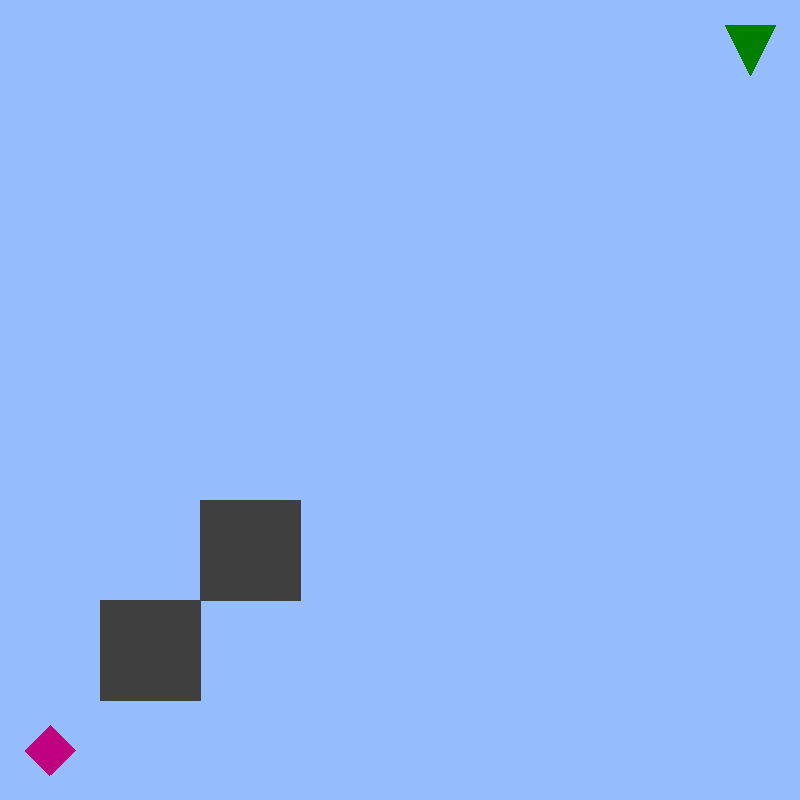

In [ ]:
Image(open('gridworld_backward_induction.gif','rb').read())

# Implementation of UCBVI

The UCBVI algorithm works as follows:

* In each episode $t$, the agent has observed $n_t$ transitions $(s_i, a_i, r_i, s_{i+1})_{i=1}^{n_t}$ of states, actions, rewards and next states.
* We estimate a model of the MDP as:
$$
\mathbf{rewards:}\quad\widehat{R}_{t(s, a)} = \frac{1}{N_t(s, a)} \sum_{i=1}^{n_t} \mathbb{1}\{s = s_i, a = a_i\} r_i
\\
\mathbf{transitions:}\quad \widehat{P}_t(s\prime|s, a) =  \frac{1}{N_t(s, a)} \sum_{i=1}^{n_t} \mathbb{1}\{s = s_i, a = a_i, s\prime=s_{i+1}\}
$$
where
$$
N_t(s, a) = \max\left(1, \sum_{i=1}^{n_t} \mathbb{1}\{s = s_i, a = a_i\} \right)
$$
* We define an appropriate exploration bonus, which is some function of the number of visits, for example
$$
B_t(s, a) \propto \sqrt{\frac{1}{N_t(s, a)}} \cdot
$$

* Then, in episode $t$, we compute $\{Q_h^t(s, a)\}_{h=1}^H$ as the ($H$-horizon) optimal value functions in the MDP whose transitions are $\widehat{P}_t$ and whose rewards are $(\widehat{R}_t + B_t)$. At step $h$ of episode $t$, the agent chooses the action $a_h^t \in \arg\max_a Q_h^t(s, a)$.

**Complete the code below to implement UCBVI.**

In [55]:
# An example of bonus function
def bonus(N):
    """input : a numpy array (nb of visits)
    output : a numpy array (bonuses)"""
    nn = np.maximum(N, 1)
    return np.sqrt(1.0/nn)

# The UCB-VI algorithm
def UCBVI(env,H, nb_episodes,verbose="off",bonus_function=bonus,gamma=1):
    """
    Parameters:
        env: environement
        bonus_function : maps the number of visits to the corresponding bonus
        H: horizon
        gamma: discount factor. Usually set to 1.0 in finite-horizon problems

    Returns:
        episode_rewards: a vector storing the sum of rewards obtained in each episode
        states_visited: a vector storing the number of states/action pairs visited until each episode
        N_sa : array of size (S,A) giving the total number of visits in each state
        Rhat : array of size (S,A) giving the estimated average rewards
        Phat : array of size (S,A,S) giving the estimated transition probabilities
        optimistic_Q : array of size (H,S,A) giving the optimistic Q function used in the last episode
    """
    S = env.observation_space.n
    A = env.action_space.n
    Phat = np.ones((S,A,S)) / S
    Rhat = np.zeros((S,A))
    N_sa = np.zeros((S,A), dtype=int) # number of visits

    N_sas = np.zeros((S,A,S), dtype=int) # number of transitions
    S_sa = np.zeros((S,A)) # cumulative rewards
    episode_rewards = np.zeros((nb_episodes,))
    states_visited = np.zeros((nb_episodes,))


    for episode in range(nb_episodes):
        sum_rewards = 0

        ### TO BE COMPLETED: RUN AN EPISODE OF UCV-VI
        s = env.reset()[0]
        optimistic_Q = np.zeros((H, S, A))

        for h in range(H):
            B = bonus_function(N_sa)
            # optimistic_Q is the optimal value of the MDP whose
            # transition probabilites = the same as before; and
            # rewards are = previous reward + exploration bonus
            optimistic_Q = backward_induction(Phat, Rhat + B, H, gamma)

            a = np.argmax(optimistic_Q[h, s, :])
            next_state, reward, done, _, _ = env.step(a)

            N_sa[s, a] += 1
            S_sa = N_sa[s, a]
            Rhat[s, a] = reward / S_sa + Rhat[s, a] * (S_sa - 1) / S_sa
            Phat[s, a, :] = Phat[s, a, :] * ((S_sa - 1) / S_sa)
            Phat[s, a, next_state] += 1 / S_sa

            sum_rewards += reward
            s = next_state

        # update sum of rewards and number of visits
        episode_rewards[episode] = sum_rewards
        states_visited[episode] = (N_sa.sum(axis=1) > 0).sum()

        if (verbose=="on"):
          # periodically display the rewards collected and visited states
          if episode % 50 == 0 or episode == 1:
            print("rewards in episode {}: {}".format(episode, episode_rewards[episode]), end = ", ")
            print("Number of visited states: ", states_visited[episode] )
            # print(V[0, :])

    return episode_rewards, states_visited, N_sa, Rhat, Phat, optimistic_Q

**1. To check whether the algorithm is working, you can visualize the amount of rewards gathered in episodes with the default bonus, as well as the number of visited states since the beginning (which measures how well the environment is being explored). Based on your findings, how many episodes seem necessary for the algorithm to behave well?**

In [ ]:
HORIZON = 200
NUM_EPISODES = 500

env = ScaleRewardWrapper(get_discrete_mountain_car_env())
rewards, cum_visits, N_sa, Rhat, Phat, optimistic_Q = UCBVI(env, H=HORIZON, nb_episodes=NUM_EPISODES,verbose="on")

rewards in episode 0: 0.0, Number of visited states:  4.0
rewards in episode 1: 0.0, Number of visited states:  4.0
rewards in episode 50: 0.0, Number of visited states:  73.0
rewards in episode 100: 35.0, Number of visited states:  77.0
rewards in episode 150: 44.0, Number of visited states:  77.0
rewards in episode 200: 86.0, Number of visited states:  77.0
rewards in episode 250: 49.0, Number of visited states:  77.0
rewards in episode 300: 0.0, Number of visited states:  77.0
rewards in episode 350: 43.0, Number of visited states:  78.0
rewards in episode 400: 38.0, Number of visited states:  78.0
rewards in episode 450: 14.0, Number of visited states:  78.0


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Text(0.5, 1.0, 'number of states visited since the first episode')

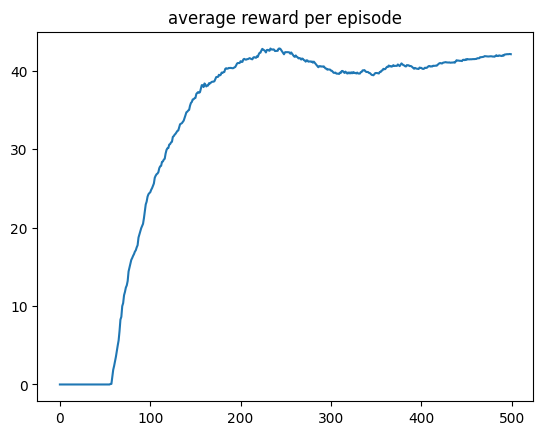

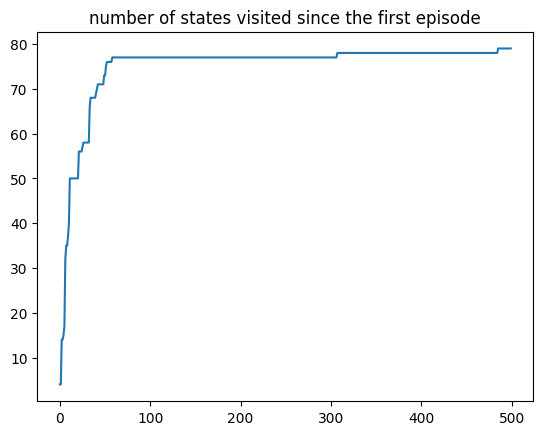

In [ ]:
plt.plot([np.cumsum(rewards)[episode]/(episode+1) for episode in range(NUM_EPISODES)])
#plt.plot(rewards)
plt.title("average reward per episode")

plt.figure(2)
plt.plot(cum_visits)
plt.title("number of states visited since the first episode")

> It seems that the algorithm has sufficiently explored the environment after about 70 steps, and it starts accumulating rewards regulary. So we can expect that the algorithm behaves well after a bit more than 70 steps.

**2. UCBVI's first purpose is not to output a candidate optimal policy, but if you want to do so, what is (are) reasonnable candidate(s)? You can check by looking how the agent behaves under this (these) policies, i.e. whether it solves the task. You can also display a 2D visualization of associated Q functions.**

> First, we can try a policy that is greedy with respect to Q_optimistic.

In [ ]:
def greedy_policy(optimistic_Q):
    return np.argmax(optimistic_Q[:-1], axis=2)

In [ ]:
policy = greedy_policy(optimistic_Q)
record_video(env,"UCB-VI-optimistic", HORIZON,policy)
Video('gym_videos/UCB-VI-optimistic/rl-video-episode-0.mp4', embed=True)

Moviepy - Building video /content/gym_videos/UCB-VI-optimistic/rl-video-episode-0.mp4.
Moviepy - Writing video /content/gym_videos/UCB-VI-optimistic/rl-video-episode-0.mp4



Moviepy - Done !
Moviepy - video ready /content/gym_videos/UCB-VI-optimistic/rl-video-episode-0.mp4
Reward sum: 1.0


Displaying the value of this policy is not possible, as it would require to perform policy evaluation, and as P and R are unknown, Monte-Carlo evaluation is the only option. Let's keep this for later. For now a proxy is to visualize $\max_{a} Q(s,a)$ when $\pi$ is greedy wrt to $Q$. For the optimistic policy, $Q$ is the optimistic Q function.


/usr/local/lib/python3.10/dist-packages/gymnasium/core.py:311: UserWarning: WARN: env.discretized_states to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.discretized_states` for environment variables or `env.get_wrapper_attr('discretized_states')` that will search the reminding wrappers.
  logger.warn(


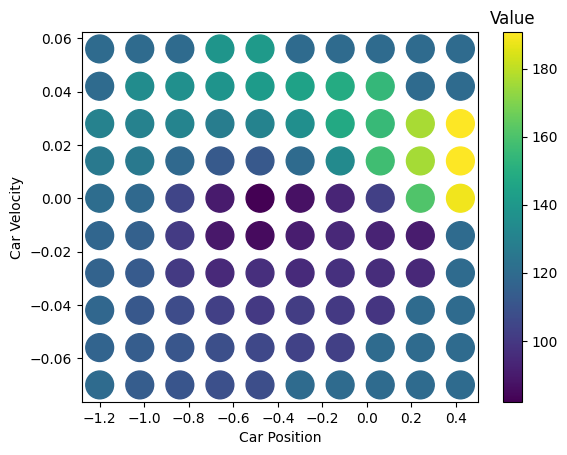

In [ ]:
Q_function = optimistic_Q ## here goes Q such that policy = greedy(Q)
value = np.max(Q_function,axis=2)
plt.scatter(env.discretized_states[0, :], env.discretized_states[1, :], c=value[0, :], s=400)
plt.xlabel('Car Position')
plt.ylabel('Car Velocity')
clb=plt.colorbar()
clb.ax.set_title('Value')
plt.show()

In theory, any algorithm with an upper bound $\mathbb{E}[R_T] \leq B_T$ on its expected regret can be used to output an $\varepsilon$-optimal policy with high probability using the following trick: run the algorithm for a sufficiently large $T$ and output a policy $\widehat{\pi}_T$ chosen at random among the first $T$ policies used by the algorithm. The point of this question is to quantify how long.    

**3. [Theory] For a given $T$, give an upper bound on the probability $\mathbb{P}(V^\star - V^{\widehat{\pi}_T} > \varepsilon)$ that depends on $T,\varepsilon$ and $B_T$ (you can use Markov's inequality). Deduce the order of magnitude of the number of episodes needed by UCB-VI to output a $\varepsilon$-optimal policy with probability $1-\delta$. Comment on the result.**

> If we select $\widehat{\pi}_T$ uniformly among the first $T$ policies, then we have $\mathbb{P}(\widehat{\pi}_T = \pi_t) = \frac{1}{T}$ for all $t=1,...,T$. With this trick we can derive an upper bound of $\mathbb{P}(V^\star - V^{\widehat{\pi}_T} > \varepsilon)$ that depends on $T,\varepsilon$ and $B_T$ as follows:
\begin{align*}
\mathbb{P}(V^\star - V^{\widehat{\pi}_T} > \varepsilon) &= \sum_{t=1}^T \mathbb{P}(V^\star - V^{\pi_t} > \varepsilon \mid \widehat{\pi}_T = \pi_t) \mathbb{P}(\widehat{\pi}_T = \pi_t)\\
& = \frac{1}{T} \sum_{t=1}^T \mathbb{P}(V^\star - V^{\pi_t} > \varepsilon \mid \widehat{\pi}_T = \pi_t)\\
& \le \frac{1}{T} \sum_{t=1}^T \frac{\mathbb{E}[V^\star - V^{\pi_t}]}{\varepsilon} \ \ \ \ \ \text{ (Markov)}\\
&= \frac{1}{T \varepsilon } \mathbb{E} \left[ \sum_{t=1}^T V^\star - V^{\pi_t} \right]\\
&= \frac{\mathbb{E} [R_T]}{T \varepsilon }\\
& \le \frac{B_T}{T \varepsilon }
\end{align*}

> With this trick, it is sufficient to select $T = \frac{B_T}{T \varepsilon}$ to guarantee that UCB-VI outputs a $\varepsilon$-optimal policy with probability $1 - \delta$, because in this case we have $\mathbb{P}(V^\star - V^{\widehat{\pi}_T} > \varepsilon) \le \delta$.

> The value of $T$ increases when we increase the precision (smaller values of $\varepsilon$) or the confidence (smaller values of $\delta$). It also depends on the regret bound $B_T$. Tighter regret bounds imply a fewer number of required episodes to meet the theoretical guarantees above.

**4. UCB-VI has actually some guarantees in terms of regret, so you can try to optimize the algorithm for the setting it is designed for.**

Explore different kind of bonuses for UCB-VI, in terms of resulting *expected* cumulative rewards. You may also compare bonus-based "directed" exploration to a model-based algorithm using instead $\epsilon$-greedy exploration.

> Indeed we know that for UCB-VI: $\mathbb{P}\left(R_T = \mathcal{O}\left(\sqrt{H^2SAT\log \left(\frac{T}{\delta} \right)}\right)\right) \le 1 - \delta$ and that there exists a worst-case lower bound of order $\sqrt{H^2SAT}$ for some Markov decision process, so we can optimize the algorithm with this theoretical setting.

 > Now let's try other bonuses of the form $B_t(s,a) \propto \sqrt{\frac{c}{N_t(s,a)}}$. This form corresponds to the theoretical exploration bonus that leads to an upper bound for UCB-VI.

In [ ]:
def bonus_c(N, c):
    """input : a numpy array (nb of visits)
    output : a numpy array (bonuses)"""
    nn = np.maximum(N, 1)
    return np.sqrt(c / nn)

In [ ]:
HORIZON = 200
NUM_EPISODES = 100

c = 0.1
bonus_fn = lambda N : bonus_c(N,c)

env = ScaleRewardWrapper(get_discrete_mountain_car_env())
rewards, cum_visits, N_sa, Rhat, Phat, optimistic_Q = UCBVI(env,H=HORIZON,nb_episodes=NUM_EPISODES,verbose="on",bonus_function=bonus_fn)

rewards in episode 0: 0.0, Number of visited states:  4.0
rewards in episode 1: 0.0, Number of visited states:  14.0
rewards in episode 50: 27.0, Number of visited states:  76.0


Text(0.5, 1.0, 'number of states visited since the first episode')

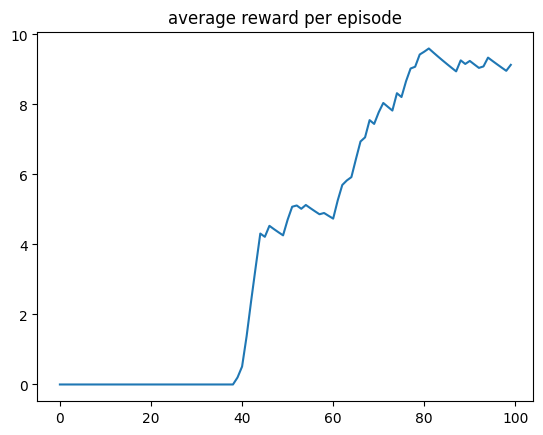

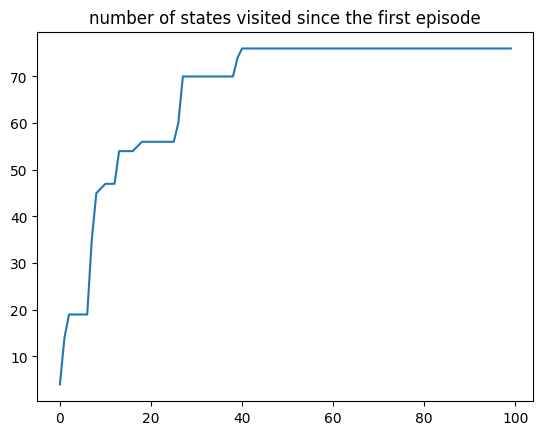

In [ ]:
plt.plot([np.cumsum(rewards)[episode]/(episode+1) for episode in range(NUM_EPISODES)])
#plt.plot(rewards)
plt.title("average reward per episode")

plt.figure(2)
plt.plot(cum_visits)
plt.title("number of states visited since the first episode")

In [ ]:
policy = greedy_policy(optimistic_Q)
record_video(env,"UCB-VI-optimistic", HORIZON,policy)
Video('gym_videos/UCB-VI-optimistic/rl-video-episode-0.mp4', embed=True)

/usr/local/lib/python3.10/dist-packages/gymnasium/wrappers/record_video.py:94: UserWarning: WARN: Overwriting existing videos at /content/gym_videos/UCB-VI-optimistic folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


Moviepy - Building video /content/gym_videos/UCB-VI-optimistic/rl-video-episode-0.mp4.
Moviepy - Writing video /content/gym_videos/UCB-VI-optimistic/rl-video-episode-0.mp4



Moviepy - Done !
Moviepy - video ready /content/gym_videos/UCB-VI-optimistic/rl-video-episode-0.mp4
Reward sum: 0.0


In [ ]:
HORIZON = 200
NUM_EPISODES = 100

c = 10
bonus_fn = lambda N : bonus_c(N,c)

env = ScaleRewardWrapper(get_discrete_mountain_car_env())
rewards, cum_visits, N_sa, Rhat, Phat, optimistic_Q = UCBVI(env,H=HORIZON,nb_episodes=NUM_EPISODES,verbose="on",bonus_function=bonus_fn)

rewards in episode 0: 0.0, Number of visited states:  10.0
rewards in episode 1: 0.0, Number of visited states:  14.0
rewards in episode 50: 51.0, Number of visited states:  76.0


Text(0.5, 1.0, 'number of states visited since the first episode')

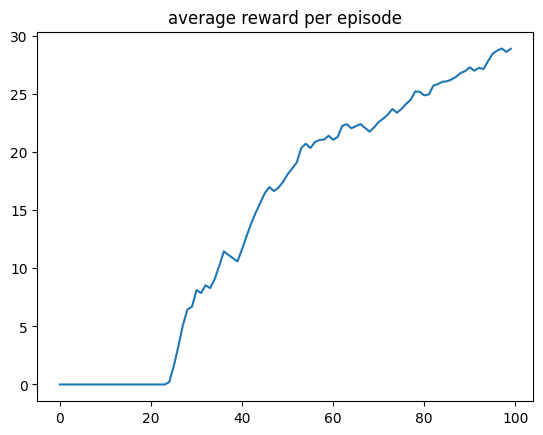

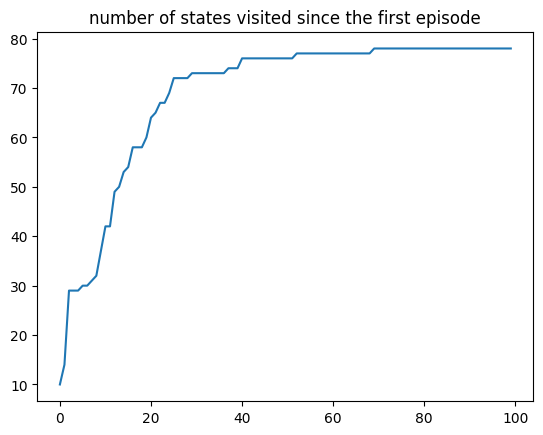

In [ ]:
plt.plot([np.cumsum(rewards)[episode]/(episode+1) for episode in range(NUM_EPISODES)])
#plt.plot(rewards)
plt.title("average reward per episode")

plt.figure(2)
plt.plot(cum_visits)
plt.title("number of states visited since the first episode")

In [ ]:
policy = greedy_policy(optimistic_Q)
record_video(env,"UCB-VI-optimistic", HORIZON,policy)
Video('gym_videos/UCB-VI-optimistic/rl-video-episode-0.mp4', embed=True)

Moviepy - Building video /content/gym_videos/UCB-VI-optimistic/rl-video-episode-0.mp4.
Moviepy - Writing video /content/gym_videos/UCB-VI-optimistic/rl-video-episode-0.mp4



Moviepy - Done !
Moviepy - video ready /content/gym_videos/UCB-VI-optimistic/rl-video-episode-0.mp4
Reward sum: 1.0


In [ ]:
HORIZON = 200
NUM_EPISODES = 100

c = 50
bonus_fn = lambda N : bonus_c(N,c)

env = ScaleRewardWrapper(get_discrete_mountain_car_env())
rewards, cum_visits, N_sa, Rhat, Phat, optimistic_Q = UCBVI(env,H=HORIZON,nb_episodes=NUM_EPISODES,verbose="on",bonus_function=bonus_fn)

rewards in episode 0: 0.0, Number of visited states:  4.0
rewards in episode 1: 0.0, Number of visited states:  4.0
rewards in episode 50: 0.0, Number of visited states:  72.0


Text(0.5, 1.0, 'number of states visited since the first episode')

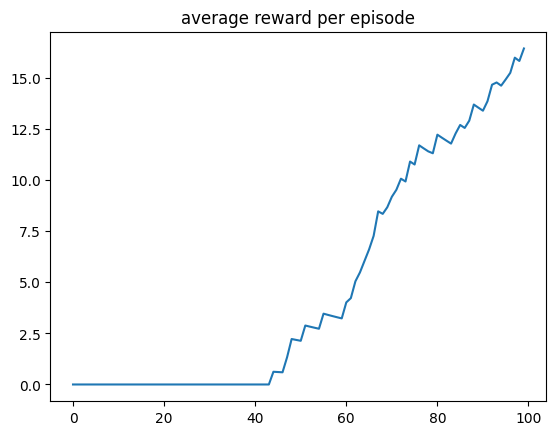

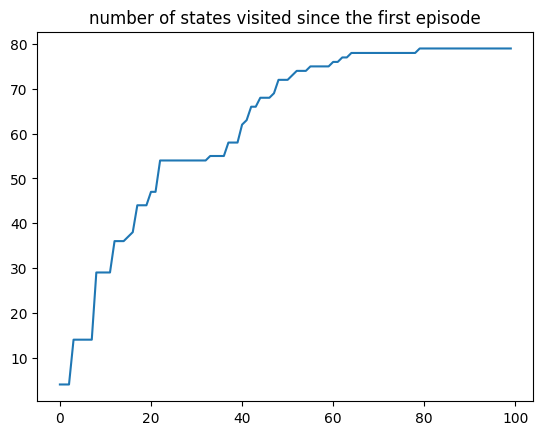

In [ ]:
plt.plot([np.cumsum(rewards)[episode]/(episode+1) for episode in range(NUM_EPISODES)])
#plt.plot(rewards)
plt.title("average reward per episode")

plt.figure(2)
plt.plot(cum_visits)
plt.title("number of states visited since the first episode")

In [ ]:
policy = greedy_policy(optimistic_Q)
record_video(env,"UCB-VI-optimistic", HORIZON,policy)
Video('gym_videos/UCB-VI-optimistic/rl-video-episode-0.mp4', embed=True)

Moviepy - Building video /content/gym_videos/UCB-VI-optimistic/rl-video-episode-0.mp4.
Moviepy - Writing video /content/gym_videos/UCB-VI-optimistic/rl-video-episode-0.mp4



Moviepy - Done !
Moviepy - video ready /content/gym_videos/UCB-VI-optimistic/rl-video-episode-0.mp4
Reward sum: 1.0


> It seems that $c = 10$ gives better results than other values of $c$, including $c=1$. We can of course further finetune $c$.

> Here, since the environment is very sparse, we may want to encourage exploration. To do so, we can try to increase exploration bonuses as follows: $B_t(s,a) \propto \left(\frac{c}{N_t(s,a)}\right)^{1/3}$.

In [69]:
def bonus2_c(N, c):
    """input : a numpy array (nb of visits)
    output : a numpy array (bonuses)"""
    nn = np.maximum(N, 1)
    return (c / nn)**(1/3)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [70]:
HORIZON = 200
NUM_EPISODES = 100

c = 0.1
bonus_fn = lambda N : bonus2_c(N,c)

env = ScaleRewardWrapper(get_discrete_mountain_car_env())
rewards, cum_visits, N_sa, Rhat, Phat, optimistic_Q = UCBVI(env,H=HORIZON,nb_episodes=NUM_EPISODES,verbose="on",bonus_function=bonus_fn)

rewards in episode 0: 0.0, Number of visited states:  4.0
rewards in episode 1: 0.0, Number of visited states:  4.0
rewards in episode 50: 44.0, Number of visited states:  77.0


Text(0.5, 1.0, 'number of states visited since the first episode')

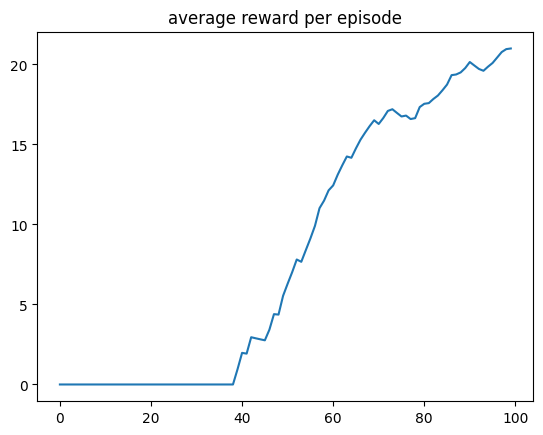

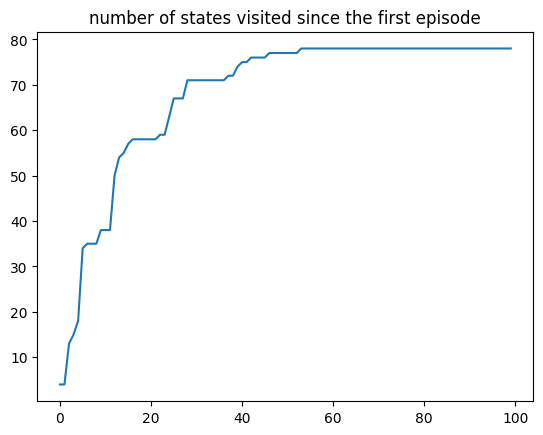

In [71]:
plt.plot([np.cumsum(rewards)[episode]/(episode+1) for episode in range(NUM_EPISODES)])
#plt.plot(rewards)
plt.title("average reward per episode")

plt.figure(2)
plt.plot(cum_visits)
plt.title("number of states visited since the first episode")

In [72]:
policy = greedy_policy(optimistic_Q)
record_video(env,"UCB-VI-optimistic", HORIZON,policy)
Video('gym_videos/UCB-VI-optimistic/rl-video-episode-0.mp4', embed=True)

/usr/local/lib/python3.10/dist-packages/gymnasium/wrappers/record_video.py:94: UserWarning: WARN: Overwriting existing videos at /content/gym_videos/UCB-VI-optimistic folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


Moviepy - Building video /content/gym_videos/UCB-VI-optimistic/rl-video-episode-0.mp4.
Moviepy - Writing video /content/gym_videos/UCB-VI-optimistic/rl-video-episode-0.mp4



Moviepy - Done !
Moviepy - video ready /content/gym_videos/UCB-VI-optimistic/rl-video-episode-0.mp4
Reward sum: 1.0


In [73]:
HORIZON = 200
NUM_EPISODES = 100

c = 1
bonus_fn = lambda N : bonus2_c(N,c)

env = ScaleRewardWrapper(get_discrete_mountain_car_env())
rewards, cum_visits, N_sa, Rhat, Phat, optimistic_Q = UCBVI(env,H=HORIZON,nb_episodes=NUM_EPISODES,verbose="on",bonus_function=bonus_fn)

rewards in episode 0: 0.0, Number of visited states:  4.0
rewards in episode 1: 0.0, Number of visited states:  4.0
rewards in episode 50: 55.0, Number of visited states:  80.0


Text(0.5, 1.0, 'number of states visited since the first episode')

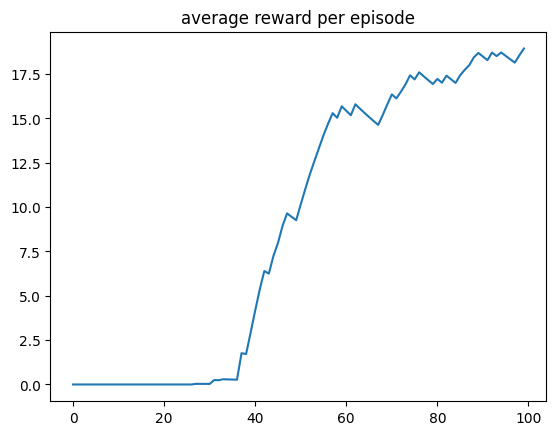

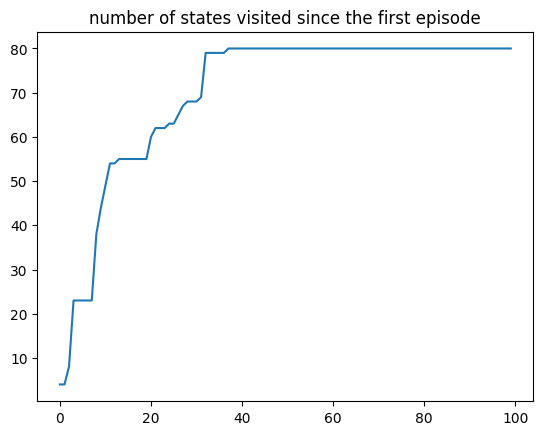

In [74]:
plt.plot([np.cumsum(rewards)[episode]/(episode+1) for episode in range(NUM_EPISODES)])
#plt.plot(rewards)
plt.title("average reward per episode")

plt.figure(2)
plt.plot(cum_visits)
plt.title("number of states visited since the first episode")

In [75]:
policy = greedy_policy(optimistic_Q)
record_video(env,"UCB-VI-optimistic", HORIZON,policy)
Video('gym_videos/UCB-VI-optimistic/rl-video-episode-0.mp4', embed=True)

Moviepy - Building video /content/gym_videos/UCB-VI-optimistic/rl-video-episode-0.mp4.
Moviepy - Writing video /content/gym_videos/UCB-VI-optimistic/rl-video-episode-0.mp4



Moviepy - Done !
Moviepy - video ready /content/gym_videos/UCB-VI-optimistic/rl-video-episode-0.mp4
Reward sum: 1.0


In [76]:
HORIZON = 200
NUM_EPISODES = 100

c = 10
bonus_fn = lambda N : bonus2_c(N,c)

env = ScaleRewardWrapper(get_discrete_mountain_car_env())
rewards, cum_visits, N_sa, Rhat, Phat, optimistic_Q = UCBVI(env,H=HORIZON,nb_episodes=NUM_EPISODES,verbose="on",bonus_function=bonus_fn)

rewards in episode 0: 0.0, Number of visited states:  4.0
rewards in episode 1: 0.0, Number of visited states:  4.0
rewards in episode 50: 0.0, Number of visited states:  78.0


Text(0.5, 1.0, 'number of states visited since the first episode')

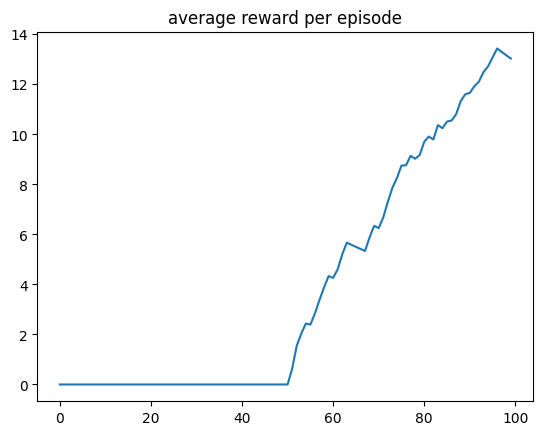

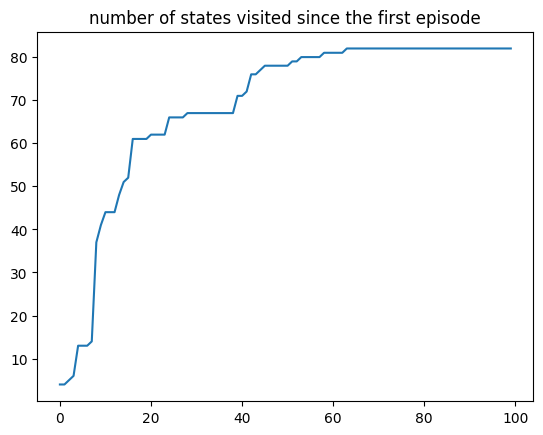

In [77]:
plt.plot([np.cumsum(rewards)[episode]/(episode+1) for episode in range(NUM_EPISODES)])
#plt.plot(rewards)
plt.title("average reward per episode")

plt.figure(2)
plt.plot(cum_visits)
plt.title("number of states visited since the first episode")

In [78]:
policy = greedy_policy(optimistic_Q)
record_video(env,"UCB-VI-optimistic", HORIZON,policy)
Video('gym_videos/UCB-VI-optimistic/rl-video-episode-0.mp4', embed=True)

Moviepy - Building video /content/gym_videos/UCB-VI-optimistic/rl-video-episode-0.mp4.
Moviepy - Writing video /content/gym_videos/UCB-VI-optimistic/rl-video-episode-0.mp4



Moviepy - Done !
Moviepy - video ready /content/gym_videos/UCB-VI-optimistic/rl-video-episode-0.mp4
Reward sum: 0.0


> With bonuses of the form $B_t(s,a) \propto \frac{c}{N_t(s,a)^{1/3}}$, learning dynamics are slightly different. With $c = 1$ we obtain interesting training dynamics. As before, we can further finetune $c$. We could also try ohter bonuses of the form $B_t(s,a) \propto \frac{c}{N_t(s,a)^\beta}$ with $\beta > 0$.

**5. [Theory] Our goal was to find a policy that manages to get the car up the hill. We chose to model this as solving an episodic MDP with a large enough horizon $H$. Could this task also be modelled as solving a discounted MDP? What value would you choose for the discount?**

> We can interpret the value of a trajectory under a $\gamma$-discounted criterion as the value of the same game under a total reward criterion but with a probability of termination $1-\gamma$ at each time step. The termination time follows a geometric distribution of parameter $1-\gamma$, so it has an expected value of $\frac{1}{1 - \gamma}$. Therefore, if we want to have termination times equal to $H$ in expectation then we should select $\gamma$ such that $\frac{1}{1 - \gamma} = H$, that is to say $\gamma = 1 - \frac{1}{H}$. For $H = 200$, we obtain $\gamma = 0.995$.

**6. Compare the best model-based algorithm found in question 4. to a model-free alternative (still in terms of cumulative rewards).**

The idea is to try to make some variant of the (discounted) Q-Learning algorithm work for this problem. Learning will however still proceed in episodes of length H, with a reset, and we will similarly monitor the (undiscounted) amount of rewards gathered in each episode, for comparison with UCBVI.

You may explore one of the following possibilities: combining $\varepsilon$-greedy exploration with a careful initialization of the Q-values, or adding some exploration bonuses to the rewards.

Careful describe the chosen algorithm as well as the results.


> We will use a Q-learning algorithm as a model-free alternative. We combine $\varepsilon$-greedy exploration with an optimistic initialization of the Q-values. Q is initialized as follows: `Q = np.ones((S,A)) * Q_init` where high values of Q_init encourage more exploration.

In [ ]:
def q_learning(env, H, nb_episodes, epsilon=0.1, alpha=0.05, gamma=0.995, epsilon_update=None, Q_init=1, verbose="off"):
    """
    Q-Learning with epsilon-greedy exploration, extended to include tracking of distinct states visited and returning the final Q-table.

    Parameters:
    - env: Environment.
    - H: Horizon per episode.
    - nb_episodes: Number of episodes.
    - epsilon: Exploration rate.
    - alpha: Learning rate.
    - Q_init: Initial value for all Q-values in the Q-table. Higher values encourage more exploration.

    Returns:
    - episode_rewards: Rewards per episode.
    - states_visited_cumulative: Cumulative count of distinct states visited by the end of each episode.
    - Q: Final Q-value table.
    """
    S = env.observation_space.n
    A = env.action_space.n

    Q = np.ones((S, A)) * Q_init

    episode_rewards = np.zeros(nb_episodes)
    states_visited = set()
    states_visited_cumulative = np.zeros(nb_episodes)

    for episode in range(nb_episodes):
        state = env.reset()[0]
        sum_rewards = 0

        for h in range(H):
            states_visited.add(state)
            # epsilon-greedy action selection
            if np.random.rand() < epsilon:
                action = env.action_space.sample()
            else:
                action = np.argmax(Q[state, :])

            next_state, reward, done, _, _ = env.step(action)

            # Q-value update
            best_next_action = np.argmax(Q[next_state, :])
            Q[state, action] += alpha * (reward + gamma * Q[next_state, best_next_action] - Q[state, action])

            sum_rewards += reward
            state = next_state


        episode_rewards[episode] = sum_rewards
        states_visited_cumulative[episode] = len(states_visited) 

        if (verbose=="on"):
          # periodically display the rewards collected and visited states
          if episode % 50 == 0 or episode == 1:
            print("rewards in episode {}: {}".format(episode, episode_rewards[episode]), end = ", ")
            print("Number of visited states: ", states_visited_cumulative[episode] )
            # print(V[0, :])


    return episode_rewards, states_visited_cumulative, Q


In [ ]:
HORIZON = 200
NUM_EPISODES = 1500

env = ScaleRewardWrapper(get_discrete_mountain_car_env())
rewards, cum_visits, optimistic_Q = q_learning(env,H=HORIZON,nb_episodes=NUM_EPISODES,verbose="on",epsilon=0.1,alpha=0.05,gamma=0.995,Q_init=1)

rewards in episode 0: 0.0, Number of visited states:  4.0
rewards in episode 1: 0.0, Number of visited states:  4.0
rewards in episode 50: 0.0, Number of visited states:  32.0
rewards in episode 100: 0.0, Number of visited states:  54.0
rewards in episode 150: 0.0, Number of visited states:  66.0
rewards in episode 200: 0.0, Number of visited states:  71.0
rewards in episode 250: 0.0, Number of visited states:  72.0
rewards in episode 300: 0.0, Number of visited states:  75.0
rewards in episode 350: 0.0, Number of visited states:  75.0
rewards in episode 400: 0.0, Number of visited states:  75.0
rewards in episode 450: 1.0, Number of visited states:  76.0
rewards in episode 500: 7.0, Number of visited states:  76.0
rewards in episode 550: 0.0, Number of visited states:  77.0
rewards in episode 600: 0.0, Number of visited states:  77.0
rewards in episode 650: 0.0, Number of visited states:  77.0
rewards in episode 700: 0.0, Number of visited states:  77.0
rewards in episode 750: 40.0, N

Text(0.5, 1.0, 'number of states visited since the first episode')

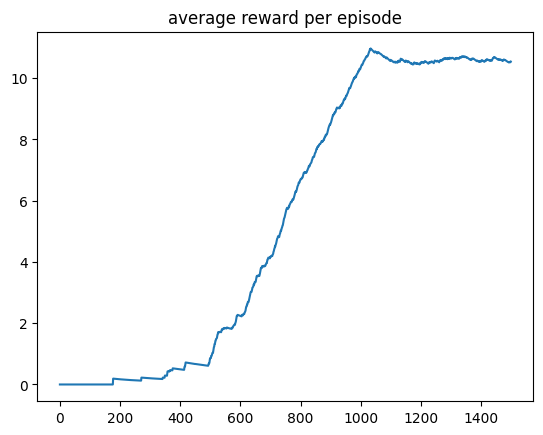

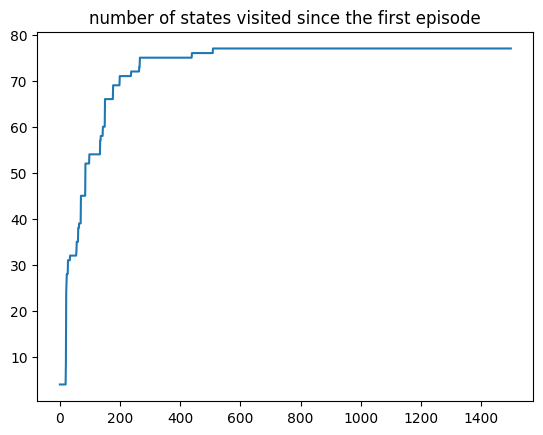

In [ ]:
plt.plot([np.cumsum(rewards)[episode]/(episode+1) for episode in range(NUM_EPISODES)])
#plt.plot(rewards)
plt.title("average reward per episode")

plt.figure(2)
plt.plot(cum_visits)
plt.title("number of states visited since the first episode")

**7. [Theory] We would now like to compare the sample complexity of the model-free algorithm to that of the model-based algorithm. How would you proceed to do that?**


(you are not required to actually do it, just specify how you would proceed given the time)

> First we need to define a performance criterion. For example, we may say that the algorithm behaves well once it has succesfully explored the majority of the state space and it starts to accumulate rewards regularly.

> We can also consider more complex criterions, like criterions involving areas under the curves of *average rewards per episode* and *number of states visited since the first episode*.

> Now we need to count the number of samples needed to reach this criterion. This depends on the algorithm architecture. For example, the performance criterion is reached in a fewer number of episodes with UCB-VI than with the model-free alternative, but UCB-VI requires a backward induction at each step. This backward induction will increase the sample complexity.